# SMA Crossover Strategy

In [1]:
import bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, time,datetime
%matplotlib inline

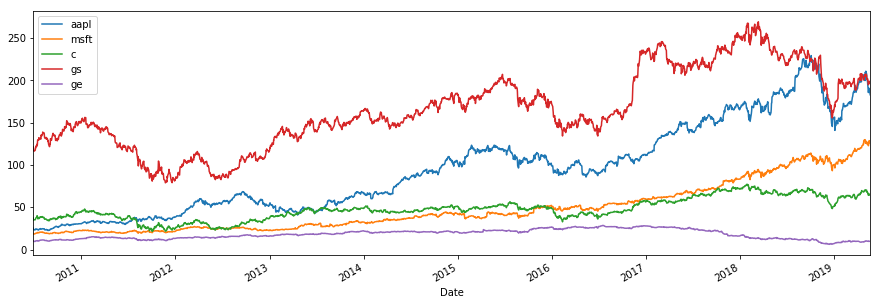

In [2]:
# download data
data = bt.get('aapl,msft,c,gs,ge', start='2010-06-29', end='2019-05-20')
data.plot(figsize=(15, 5))

In [3]:
class WeighTarget(bt.Algo):
    
    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.ix[target.now]

            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

### 策略:長短期移動平均交叉法
#### 短期(20days)sma超過長期sma(240days)之交叉，表看漲→買進
#### 短期(20days)sma低於長期sma(240days)之交叉，表看跌→賣出

In [4]:
# ma cross backtest
def ma_cross(ticker, start='2010-06-29', end='2019-05-20',
             short_ma=20, long_ma=240, name='ma_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start, end=end)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0

    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

In [5]:
# these will be the child strategies
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')
t3 = ma_cross('c', name='c_ma_cros')
t4 = ma_cross('gs', name='gs_ma_cross')
t5 = ma_cross('ge', name='ge_ma_cross')

# let's extract the data object
data = bt.merge(t1.data, t2.data, t3.data, t4.data, t5.data)

# now we create the parent strategy
# we specify the children to be the two
# strategies created above
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()],
                [t1.strategy, t2.strategy, t3.strategy, t4.strategy, t5.strategy])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)
res.display()

s


C:\Users\veryv\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
C:\Users\veryv\Anaconda3\lib\site-packages\ffn\core.py:1411: RuntimeWarning: divide by zero encountered in true_divide
  vol = np.divide(1. , np.std(returns,ddof=1) )


0% [############################# ] 100% | ETA: 00:00:02Stat                 s
-------------------  ----------
Start                2010-06-26
End                  2019-05-20
Risk-free rate       0.00%

Total Return         83.24%
Daily Sharpe         0.62
Daily Sortino        0.98
CAGR                 7.04%
Max Drawdown         -24.13%
Calmar Ratio         0.29

MTD                  -2.94%
3m                   -2.82%
6m                   -6.83%
YTD                  -16.21%
1Y                   6.44%
3Y (ann.)            17.88%
5Y (ann.)            8.11%
10Y (ann.)           7.04%
Since Incep. (ann.)  7.04%

Daily Sharpe         0.62
Daily Sortino        0.98
Daily Mean (ann.)    7.56%
Daily Vol (ann.)     12.23%
Daily Skew           -0.29
Daily Kurt           2.85
Best Day             4.17%
Worst Day            -4.19%

Monthly Sharpe       0.61
Monthly Sortino      0.98
Monthly Mean (ann.)  7.60%
Monthly Vol (ann.)   12.55%
Monthly Skew         -0.70
Monthly Kurt         2.34
Best Mon

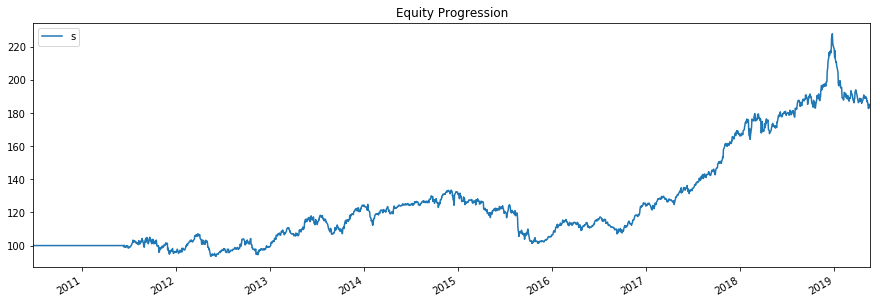

In [6]:
res.plot()